# Object quantification workflow (batch)

---
*notebook based on the material for the "Introduction to Image Analysis" Workshop*

*Stefania Marcotti (stefania.marcotti@crick.ac.uk)*

*CC-BY-SA-4.0 license: creativecommons.org/licenses/by-sa/4.0/*

---

We now aim to analyse all the images available in the `Data/idr0028/` folder, with the pipeline illustrated in the [`analysis_single_image.ipynb` notebook](https://github.com/FrancisCrickInstitute/from-notebook-to-pipeline/blob/main/Scripts/analysis_single_image.ipynb). 

The workflow will perform the following operations:
* Segment the cell nuclei
* Segment the cell cytoplasm
* Analyse the intensity distribution of a marker in both regions

### Import libraries

In [5]:
import os

import numpy as np

from skimage import io
from skimage import filters
from skimage import measure
from skimage import segmentation
from skimage import morphology

import matplotlib.pyplot as plt

import pandas as pd

from scipy import ndimage

### Import data
This time we are reading all of the files in the folder - note the use of the wildcard `*`!

In [6]:
# get the list of all files and directories
path = '../Data/idr0028/'
dir_list = os.listdir(path)

print(*dir_list, sep='\n')

.DS_Store
003003-15.tif
003003-14.tif
003003-16.tif
003003-17.tif
003003-13.tif
003003-12.tif
003003-10.tif
003003-11.tif
003003-19.tif
003003-18.tif


In [3]:
# define spatial resolution (x,y)
spatial_resolution = (0.6549,0.6549)

In [4]:
# read all .tif files in folder
im_read = io.imread('../Data/idr0028/*.tif')

In [5]:
# check the dimensions of the object
print('Object dimensions:', im_read.shape)

Object dimensions: (10, 501, 667, 4)


The image dimensions are currently in the (n, y, x, c) format. Ideally, by convention, we would want the dimensions of the image to be (n, c, y, x). We can rearrange the dimensions by using the numpy function `transpose`.

In [6]:
im_all = np.transpose(im_read, (0, 3, 1, 2))
print('New object dimensions:', im_all.shape)

New object dimensions: (10, 4, 501, 667)


We can visualise some example images by running the cell below. The variable `im_idx` indicates which image we want to open (first=0, second=1, ...)

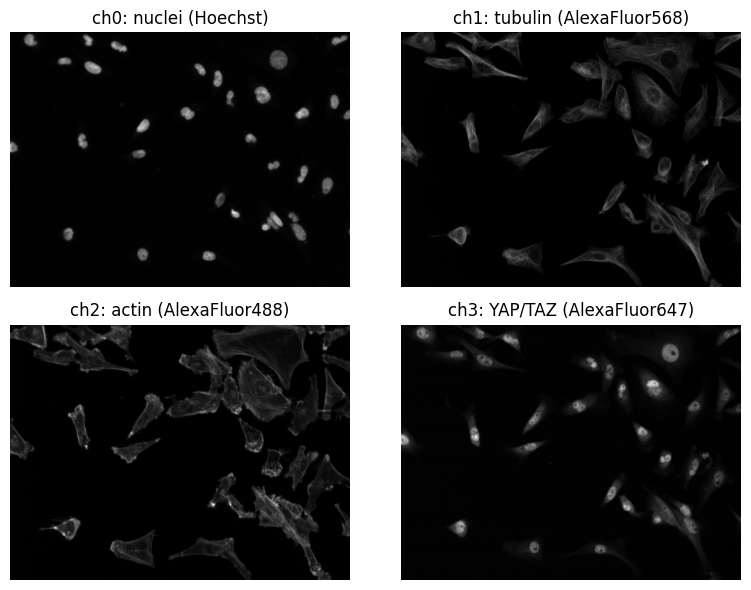

In [7]:
# select image
im_idx = 3
im = im_all[im_idx,]

# display all channels 
fig, axs = plt.subplots(2, 2, figsize=(8,6))

axs[0, 0].imshow(im[0,], cmap='gray')
axs[0, 0].set_title('ch0: nuclei (Hoechst)')
axs[0, 0].axis('off')

axs[0, 1].imshow(im[1,], cmap='gray')
axs[0, 1].set_title('ch1: tubulin (AlexaFluor568)')
axs[0, 1].axis('off')

axs[1, 0].imshow(im[2,], cmap='gray')
axs[1, 0].set_title('ch2: actin (AlexaFluor488)')
axs[1, 0].axis('off')

axs[1, 1].imshow(im[3,], cmap='gray')
axs[1, 1].set_title('ch3: YAP/TAZ (AlexaFluor647)')
axs[1, 1].axis('off')

plt.tight_layout()

### Perform the analysis on one image at a time
By using a `for` loop, we can open one image at a time and perform the same pipeline as before to quantify objects. We can then append the results in a long list where each cell is an n=1.

In [8]:
# initialise output and create output folder
props_df_out = pd.DataFrame()
out_path = path+'label_masks/'
os.makedirs(out_path, exist_ok=True)

# set up for loop for all the images available in the folder
for im_idx in range(im_all.shape[0]):

    # open image
    im = im_all[im_idx,]
    
    # separate channels
    nuclei = im[0,]
    cytoplasm = im[1,]
    YAP = im[3,]

    # nuclei: filter with Gaussian
    nuclei_gauss = filters.gaussian(nuclei, sigma=2)
    # nuclei: threshold with Otsu
    threshold_nuclei = filters.threshold_otsu(nuclei_gauss)
    nuclei_threshold = nuclei_gauss >= threshold_nuclei
    # nuclei: label mask
    nuclei_labels = measure.label(nuclei_threshold)
    
    # cells: filter with Gaussian
    cell_gauss = filters.gaussian(cytoplasm, sigma=2)
    # cells: threshold with Otsu
    threshold_cell = filters.threshold_otsu(cell_gauss)
    cell_threshold = cell_gauss >= threshold_cell
    # cells: fill holes in binary mask
    cell_threshold = ndimage.binary_fill_holes(cell_threshold)
    # cells: label mask (seeded watershed)
    cell_labels = segmentation.watershed(cell_gauss, markers=nuclei_labels, mask=cell_threshold, compactness=2)
    cell_labels = segmentation.clear_border(cell_labels)
    # cells: save label mask
    cell_file_name = out_path+dir_list[im_idx][0:-4]+'_labels_cells.tif'
    io.imsave(cell_file_name, cell_labels)

    # nuclei: clean mask to keep only cells where the cytoplasm was detected
    boolean_mask = np.isin(nuclei_labels, np.unique(cell_labels))
    nuclei_labels_clean = np.zeros_like(nuclei_labels)
    nuclei_labels_clean[boolean_mask] = nuclei_labels[boolean_mask]
    # nuclei: save label mask
    nuclei_file_name = out_path+dir_list[im_idx][0:-4]+'_labels_nuclei.tif'
    io.imsave(nuclei_file_name, nuclei_labels_clean)

    # cytoplasm: obtain mask from subtracting nuclei from cells
    cytoplasm_labels = cell_labels - nuclei_labels_clean
    cytoplasm_labels[cytoplasm_labels<0]=0
    # cytoplasm: save label mask
    cytoplasm_file_name = out_path+dir_list[im_idx][0:-4]+'_labels_cytoplasm.tif'
    io.imsave(cytoplasm_file_name, cytoplasm_labels)

    # measure properties
    props_cell_area = pd.DataFrame(measure.regionprops_table(cell_labels, properties=['area', 'label'], spacing=spatial_resolution))
    props_nuclei_YAP = pd.DataFrame(measure.regionprops_table(nuclei_labels_clean, YAP, properties=['intensity_mean', 'label']))
    props_nuclei_YAP.columns = ['intensity_mean_YAP_nuclei', 'label']
    props_cytoplasm_YAP = pd.DataFrame(measure.regionprops_table(cytoplasm_labels, YAP, properties=['intensity_mean', 'label']))
    props_cytoplasm_YAP.columns = ['intensity_mean_YAP_cytoplasm', 'label']
    # create single dataframe
    props_df = props_cell_area.merge(props_nuclei_YAP, on='label', how='outer')
    props_df = props_df.merge(props_cytoplasm_YAP, on='label', how='outer')
    props_df = props_df[['label', 'area', 'intensity_mean_YAP_nuclei', 'intensity_mean_YAP_cytoplasm']]
    props_df.columns = ['Object_label', 'Cell_area_um2', 'YAP_mean_intensity_nuclei', 'YAP_mean_intensity_cytoplasm']
    # add YAP ratio, image ID and object ID
    props_df['YAP_mean_intensity_ratio'] = props_df['YAP_mean_intensity_nuclei'] / props_df['YAP_mean_intensity_cytoplasm']
    props_df['Image_ID'] = dir_list[im_idx]
    # add to output dataframe
    props_df_out = pd.concat([props_df_out, pd.DataFrame(props_df)], ignore_index=True)

# save dataframe as a csv file
props_df_out.to_csv(out_path+'results_jupyter.csv')

/opt/miniconda3/envs/notebook-pipeline-env/lib/python3.14/site-packages/skimage/_shared/utils.py:386: UserWarning: ../Data/idr0028/label_masks/.DS_S_labels_cells.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/notebook-pipeline-env/lib/python3.14/site-packages/skimage/_shared/utils.py:386: UserWarning: ../Data/idr0028/label_masks/.DS_S_labels_nuclei.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/notebook-pipeline-env/lib/python3.14/site-packages/skimage/_shared/utils.py:386: UserWarning: ../Data/idr0028/label_masks/.DS_S_labels_cytoplasm.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/notebook-pipeline-env/lib/python3.14/site-packages/skimage/_shared/utils.py:386: UserWarning: ../Data/idr0028/label_masks/003003-15_labels_cells.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/notebook-pipeline-env/lib/python3.14/site-packages/skimage/_shared/utils.py:386: UserW

In [9]:
# show the beginning of the properties dataframe
props_df_out.head()

,Object_label,Cell_area_um2,YAP_mean_intensity_nuclei,YAP_mean_intensity_cytoplasm,YAP_mean_intensity_ratio,Image_ID
0,3,249.616314,82.718935,30.275093,2.732244,.DS_Store
1,4,460.632167,166.993266,30.697555,5.439953,.DS_Store
2,6,579.435808,168.620952,49.348668,3.416930,.DS_Store
3,8,643.769909,190.025788,38.465278,4.940190,.DS_Store
4,9,930.700002,90.184300,33.410944,2.699244,.DS_Store


In [10]:
# how many objects did we analyse?
print('We analysed', len(props_df_out), 'objects in', im_all.shape[0], 'images')

We analysed 188 objects in 10 images
